In [1]:
from skimage.transform import pyramid_gaussian, resize
import os
import cv2
import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import time
from matplotlib import pyplot as plt
np.set_printoptions(threshold=np.nan)

In [2]:
#Constants.
IMG_HEIGHT = 64
IMG_WIDTH = 64
IMG_CHANNELs = 3

PYRAMID_LEVEL = 4 #excluding the original image as a level.

CONVERSION_FACTOR = 6/15.5 #number of pixels per degree. Here, 15.5 is the display size in degree (size used in the experiment).

FOVEA = 2 #in degrees

FOVEA_RADIUS = int(np.round(FOVEA/CONVERSION_FACTOR)) #In pixels

BATCH_SIZE = 32

In [3]:
#setup mapping of fixated location to its corresponding x,y coordinate in the image.
fixated_location = 0
FIXATION_DICT = {}
hor = 5
ver = 5
for row in range(7):
    for col in range(7):
        FIXATION_DICT[str(fixated_location)] = (hor, ver)
        fixated_location += 1
        hor = hor +  9
    ver = ver +  9
    hor = 5

In [5]:
class DRDataset(Dataset):
    '''
    Dataset object to read images and refactor them so that it's
    suitable for training.
    
    Arguments:
    ----------
    file_name: name of the h5py dataset file.
    root_dir: string value path to the h5py dataset file.
    transform: python function to apply any transformation to images. 
    '''
    def __init__(self, file_name, root_dir, transform=None):
        path = os.path.join(root_dir,file_name)
        self.dr_data = h5py.File(path, 'r')
        self.transform = transform
    
    def __len__(self):
        return len(self.dr_data["Images"])
    
    def __getitem__(self, idx):
        
        image = self.dr_data["Images"][idx]
        image = image.astype('uint8')
        colour_label = self.dr_data["col_red_loc"][idx]
        shape_label = self.dr_data["shape_o_loc"][idx]
        probability = np.concatenate((colour_label, shape_label), axis=None)
        
        fixation_loc = FIXATION_DICT[str(np.random.randint(49))]
        
        sample = {'image': image, 'label': probability}
        
        if self.transform:
            sample['image'] = self.transform(sample['image'], fixation_loc[0], fixation_loc[1])       
        
        
        
        return sample
        
    


In [6]:
'''
Set of python functions to generate Human like Foveated Vision.
This Jupyter Notebook block is just to test if things are working.
'''

    def get_eccentricity(fixated_x, fixated_y):
        #Generate a mask with shape similar to the image.
        mask = 255*np.ones((IMG_HEIGHT, IMG_WIDTH), dtype='uint8')
    
        #Fovea is represented as a circle at fixated_x, fixated_y of radius FOVEA_RADIUS.
        cv2.circle(mask, (fixated_x, fixated_y), FOVEA_RADIUS, 0, -1)
    
        #Apply distance transform to mask. Open cv implementation of ecludian distance from fovea.
        eccentricity = cv2.distanceTransform(mask, cv2.DIST_L2, 3)
        eccentricity = eccentricity/CONVERSION_FACTOR
        eccentricity = (eccentricity / np.max(eccentricity)) * PYRAMID_LEVEL
        eccentricity = np.round(eccentricity)
        eccentricity = eccentricity.astype(np.int)
    
        return eccentricity
    
    # Function to generate Guassian Image Pyramid.
    def smooth_pyramid(image, layers=4):
        pyr_img = []
        for (i, resized) in enumerate(pyramid_gaussian(image, max_layer=layers, downscale=1.7, multichannel=True)):
            pyr_img.append(resize(resized, (64,64), anti_aliasing=False, preserve_range=True, anti_aliasing_sigma=i**2, mode='constant'))
        return pyr_img

    # My function to generate human like foveated vision.
    def sampling(image, fixate_x, fixate_y):
        eccentricity = get_eccentricity(fixate_x, fixate_y)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2XYZ)
        pyramid = smooth_pyramid(image, PYRAMID_LEVEL)
        im_ = np.zeros(image.shape)
        for ecc in range(np.max(eccentricity)+1):
            i  = np.argwhere(eccentricity == ecc)
            if len(i) > 0:
                im_[i[:,0], i[:,1]] = pyramid[ecc][i[:,0], i[:,1]]
        return im_

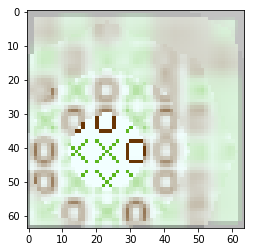

In [7]:
# Notebook Block to test if everything is working fine.
dr_dataset = DRDataset(file_name='dr_data_all.h5', root_dir='.', transform=sampling)
sample = dr_dataset[15000]
plt.imshow(sample['image'][:,:,:])
plt.show()
#plt.imshow(dr_dataset.dr_data["Img_"+str(15000)][:])
#plt.show()
#sample['image'] = np.swapaxes(sample['image'], 2, 1)
#sample['image'] = np.swapaxes(sample['image'], 1, 0)
#plt.imshow(sample['image'][1,:,:])
#plt.show()


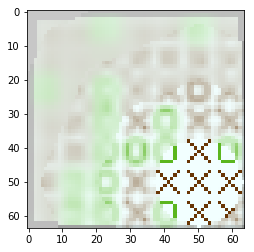

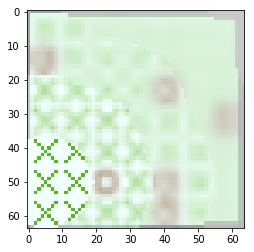

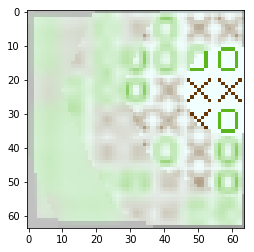

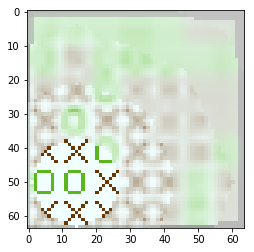

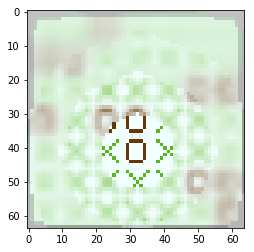

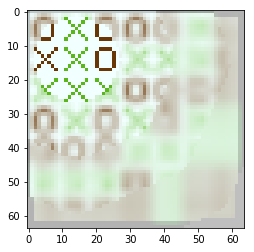

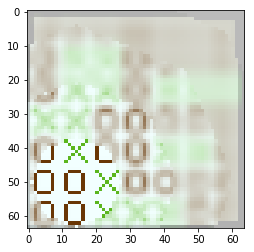

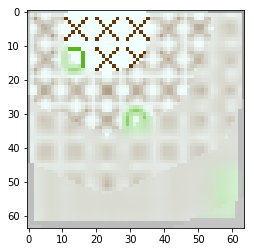

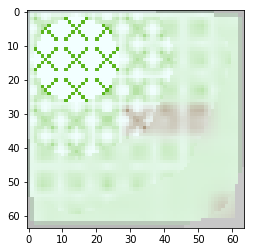

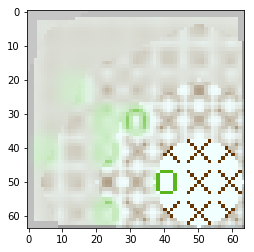

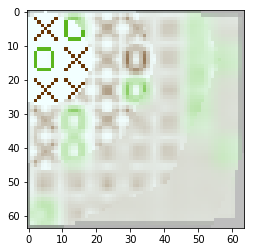

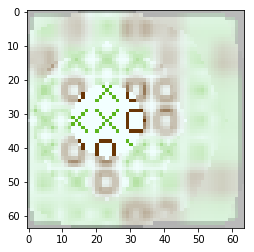

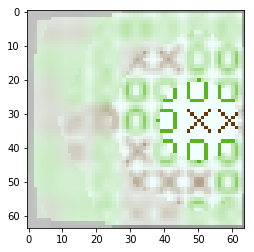

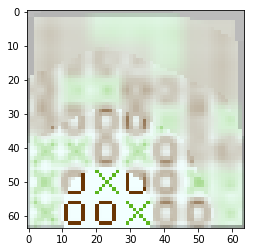

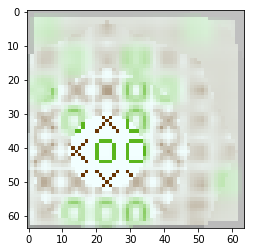

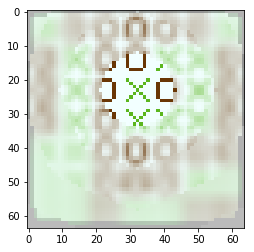

In [8]:
dataloader = DataLoader(dr_dataset, batch_size=16, shuffle=True, num_workers=1)
        
data_sample = next(iter(dataloader))
for i in range(16):
    plt.imshow(data_sample['image'][i,:,:,:])
    plt.show()

In [9]:
'''
Classes for the Neural Network Architecture. The first part is a image classification problem that is being solved.
Network takes input a noisy image and outputs presence and absence of colour red and shape O.
'''
class Unit(nn.Module):
    '''
    A Class to define single 'Unit' in the Architecture. 
    Unit Consists of a CNN layer, a Batch Normalisation layer and a Non-linear activation layer.
    
    Arguments:
    ---------
    in_channel: number of channels as an input to CNN layer.
    out_channel: number of channels as an output to CNN layer.
    '''
    def __init__(self,in_channels,out_channels, padding):
        super(Unit,self).__init__()

        self.conv = nn.Conv2d(in_channels=in_channels,kernel_size=3,out_channels=out_channels,stride=1,padding=padding)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()

    def forward(self,input):
        '''
        A routine that takes input and performs a single feed-forward step through the Unit. 
        '''
        output = self.conv(input)
        output = self.bn(output)
        output = self.relu(output)
        return output

class Network(nn.Module):
    '''
    Class that defines the Neural Network architecture.
    '''
    def __init__(self):
        super(Network, self).__init__()
        
        self.unit1 = Unit(in_channels=3,out_channels=8, padding=0)
        self.unit2 = Unit(in_channels=8,out_channels=16, padding=0)
        self.unit3 = Unit(in_channels=16,out_channels=24, padding=0)
        self.unit4 = Unit(in_channels=24,out_channels=32, padding=0)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.unit5 = Unit(in_channels=32,out_channels=32, padding=1)
        self.unit6 = Unit(in_channels=32,out_channels=32, padding=1)
        self.unit7 = Unit(in_channels=32,out_channels=32, padding=1)
        
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.unit8 = Unit(in_channels=32,out_channels=32, padding=1)
        self.unit9 = Unit(in_channels=32,out_channels=32, padding=1)
        
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        
        self.unit10 = Unit(in_channels=32,out_channels=32, padding=1)
        
        self.net = nn.Sequential(self.unit1, self.unit2, self.unit3, self.unit4, self.pool1, self.unit5, self.unit6, \
                                 self.unit7, self.pool2, self.unit8, self.unit9, self.pool3,  self.unit10)

        self.fc1 = nn.Linear(in_features=7 * 7 * 32, out_features=392)
        self.activation1 = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(in_features=392, out_features=98)
        self.activation2 = nn.Sigmoid()

    def forward(self, input):
        '''
        A routine that takes input and performs a single feed-forward step through the Network. 
        '''
        output = self.net(input)
        output = output.view(-1, 7 * 7 * 32)
        output = self.fc1(output)
        output = self.activation1(output)
        output = self.dropout(output)
        output = self.fc2(output)
        output = self.activation2(output)
        return output

In [10]:
# Display the architecture.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
model = Network().to(device)

summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 62, 62]             224
            Conv2d-2            [-1, 8, 62, 62]             224
       BatchNorm2d-3            [-1, 8, 62, 62]              16
       BatchNorm2d-4            [-1, 8, 62, 62]              16
              ReLU-5            [-1, 8, 62, 62]               0
              ReLU-6            [-1, 8, 62, 62]               0
              Unit-7            [-1, 8, 62, 62]               0
              Unit-8            [-1, 8, 62, 62]               0
            Conv2d-9           [-1, 16, 60, 60]           1,168
           Conv2d-10           [-1, 16, 60, 60]           1,168
      BatchNorm2d-11           [-1, 16, 60, 60]              32
      BatchNorm2d-12           [-1, 16, 60, 60]              32
             ReLU-13           [-1, 16, 60, 60]               0
             ReLU-14           [-1, 16,

In [13]:
class Model():
    def __init__(self, learning_rate):
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.network = Network().to(self.device)
        self.criterion = nn.MSELoss(reduce=False)
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=learning_rate);
        self.dr_dataset = DRDataset(file_name='dr_data_all.h5', root_dir='.', transform=self.sampling)
        self.dataloader = DataLoader(self.dr_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
        self.losses = []
        
    def train(self, num_epochs):
        
        dataiter = iter(self.dataloader)
        for epoch in range(num_epochs):
            data_sample = dataiter.next()
            data_sample['image'] = np.swapaxes(data_sample['image'], 3, 2)
            data_sample['image'] = np.swapaxes(data_sample['image'], 2, 1)
            images = Variable(data_sample['image'].float().to(self.device))
            labels = Variable(data_sample['label'].float().to(self.device))
                
            # Forward + Backward + Optimize
            self.optimizer.zero_grad()
            outputs = self.network(images)
            loss = self.criterion(outputs, labels).sum()
            loss = loss/BATCH_SIZE
            loss.backward()
            self.optimizer.step() 
            self.losses.append(loss.item());
                
            if (epoch+1) % 100 == 0:
                print ('Epoch : %d/%d,  Loss: %.4f'%(epoch+1, num_epochs, np.mean(self.losses[-50:])))
        
        return self.losses

    def get_eccentricity(self, fixated_x, fixated_y):
        #Generate a mask with shape similar to the image.
        mask = 255*np.ones((IMG_HEIGHT, IMG_WIDTH), dtype='uint8')
    
        #Fovea is represented as a circle at fixated_x, fixated_y of radius FOVEA_RADIUS.
        cv2.circle(mask, (fixated_x, fixated_y), FOVEA_RADIUS, 0, -1)
    
        #Apply distance transform to mask. Open cv implementation of ecludian distance from fovea.
        eccentricity = cv2.distanceTransform(mask, cv2.DIST_L2, 3)
        eccentricity = eccentricity/CONVERSION_FACTOR
        eccentricity = (eccentricity / np.max(eccentricity)) * PYRAMID_LEVEL
        eccentricity = np.round(eccentricity)
        eccentricity = eccentricity.astype(np.int)
    
        return eccentricity

    def smooth_pyramid(self, image, layers=4):
        pyr_img = []
        for (i, resized) in enumerate(pyramid_gaussian(image, max_layer=layers, downscale=2, multichannel=True)):
            pyr_img.append(resize(resized, (64,64), anti_aliasing=False, preserve_range=True, anti_aliasing_sigma=i**2, mode='constant'))
        return pyr_img


    def sampling(self, image, fixate_x, fixate_y):
        eccentricity = self.get_eccentricity(fixate_x, fixate_y)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
        pyramid = self.smooth_pyramid(image, PYRAMID_LEVEL)
        im_ = np.zeros(image.shape)
        for ecc in range(np.max(eccentricity)+1):
            i  = np.argwhere(eccentricity == ecc)
            if len(i) > 0:
                im_[i[:,0], i[:,1]] = pyramid[ecc][i[:,0], i[:,1]]
        return im_

In [39]:
#model = Model(0.0001)
loss_list = model.train(800)

Epoch : 100/800,  Loss: 0.6493
Epoch : 200/800,  Loss: 0.6713
Epoch : 300/800,  Loss: 0.6464
Epoch : 400/800,  Loss: 0.6417
Epoch : 500/800,  Loss: 0.6813
Epoch : 600/800,  Loss: 0.6706
Epoch : 700/800,  Loss: 0.6354
Epoch : 800/800,  Loss: 0.6478


In [54]:
torch.save(model.network.state_dict(), "./Lab_Model")

9600


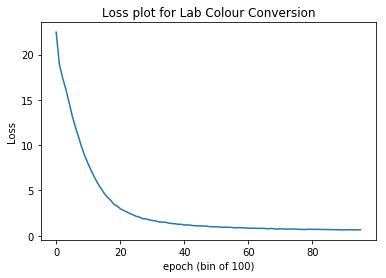

In [40]:
bin = 100
mean_y = []
print(len(loss_list))
for i in range(int(len(loss_list)/100)):
    mean_y.append(np.mean(loss_list[i*100:i*100+100]))
    
x = range(len(mean_y))
plt.plot(x, mean_y)
plt.xlabel('epoch (bin of 100)')
plt.ylabel('Loss')
plt.title('Loss plot for Lab Colour Conversion')
plt.show()
#plt.savefig('loss-plot-lab.png')

In [41]:
f = h5py.File('dr_data.h5', 'r')

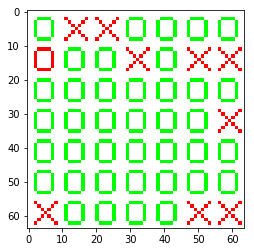

In [42]:
plt.imshow(f['Images'][5001])

In [43]:
trans_img = model.sampling(f['Images'][5001].astype('uint8'), 32, 32)
trans_img.shape

(64, 64, 3)

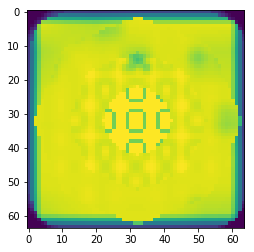

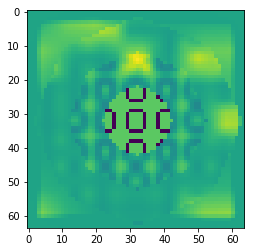

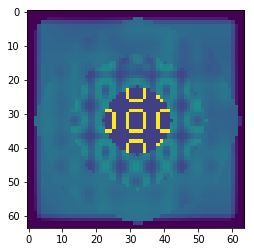

In [44]:
plt.imshow(trans_img[:][:,:,0])
plt.show()
#plt.savefig('colour-lab-1.png')
plt.imshow(trans_img[:][:,:,1])
plt.show()
#plt.savefig('colour-lab-2.png')
plt.imshow(trans_img[:][:,:,2])
plt.show()
#plt.savefig('colour-lab-3.png')

In [45]:
trans_img = trans_img.reshape(-1,64,64,3)


In [46]:
trans_img.shape

(1, 64, 64, 3)

In [47]:
trans_img = np.swapaxes(trans_img, 3, 2)
trans_img = np.swapaxes(trans_img, 2, 1)


In [48]:
trans_img = torch.tensor(trans_img)
out = model.network(trans_img.float().to("cuda"))

In [49]:
red_colour = out[0][0:49].reshape((7,7)).detach().cpu().numpy()

In [50]:
o_shape = out[0][49:98].reshape((7,7)).detach().cpu().numpy()

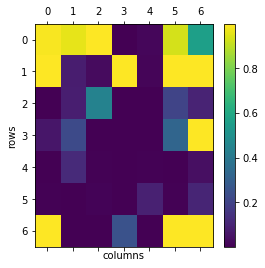

In [51]:
im = plt.matshow(red_colour, aspect='auto') # pl is pylab imported a pl
plt.colorbar(im)
plt.xlabel('columns')
plt.ylabel('rows')
plt.show()
#plt.savefig('red-colour-prob.png')

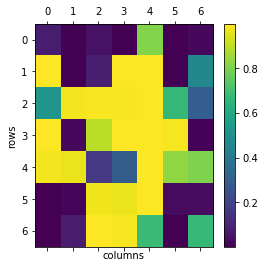

In [52]:
im = plt.matshow(o_shape, aspect='auto') # pl is pylab imported a pl
plt.colorbar(im)
plt.xlabel('columns')
plt.ylabel('rows')
plt.show()
#plt.savefig('o-shape-prob.png')

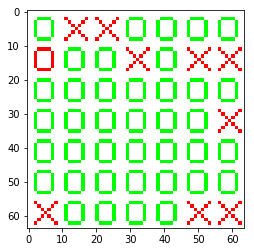

In [53]:
plt.imshow(f['Images'][5001])
#plt.savefig('original.png')

In [14]:
a = [0,1,2,3,4,5,6,7,8,9]
a[-5:]

[5, 6, 7, 8, 9]